# RAG Workflow with Reranking

This notebook walks through setting up a `Workflow` to perform basic RAG with reranking.

#   防断开

In [20]:
#@markdown <h3>← 输入了代码后运行以防止断开</h>


import IPython
from google.colab import output

display(IPython.display.Javascript('''
 function ClickConnect(){
   btn = document.querySelector("colab-connect-button")
   if (btn != null){
     console.log("Click colab-connect-button");
     btn.click()
     }

   btn = document.getElementById('ok')
   if (btn != null){
     console.log("Click reconnect");
     btn.click()
     }
  }

setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


In [ ]:
function ConnectButton(){
    console.log("Connect pushed");
    document.querySelector("#connect").click()
}
setInterval(ConnectButton,60000);


# APP begin

In [2]:
!pip install -U llama-index

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.3/361.3 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing in

In [3]:
import os

os.environ["DEEPSEEK_API_KEY"] = "sk-"

### Get Data

In [5]:
!mkdir -p data
!wget --user-agent "Mozilla" "https://arxiv.org/pdf/2307.09288.pdf" -O "data/llama2.pdf"

--2024-08-15 02:13:44--  https://arxiv.org/pdf/2307.09288.pdf
Resolving arxiv.org (arxiv.org)... 151.101.195.42, 151.101.67.42, 151.101.3.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.195.42|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://arxiv.org/pdf/2307.09288 [following]
--2024-08-15 02:13:45--  http://arxiv.org/pdf/2307.09288
Connecting to arxiv.org (arxiv.org)|151.101.195.42|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13661300 (13M) [application/pdf]
Saving to: ‘data/llama2.pdf’

data/llama2.pdf     100%[===================>]  13.03M  --.-KB/s    in 0.1s    

2024-08-15 02:13:45 (96.4 MB/s) - ‘data/llama2.pdf’ saved [13661300/13661300]



Since workflows are async first, this all runs fine in a notebook. If you were running in your own code, you would want to use `asyncio.run()` to start an async event loop if one isn't already running.

```python
async def main():
    <async code>

if __name__ == "__main__":
    import asyncio
    asyncio.run(main())
```

# LLM Env


In [7]:
!pip install llama_index-llms-openai_like
!pip install llama_index-embeddings-huggingface

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [9]:
import os
import logging
import sys
from llama_index.llms.openai_like import OpenAILike
from llama_index.core import Settings, ServiceContext
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# 配置日志
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

# 定义DeepSpeed model
llm = OpenAILike(model="deepseek-chat",
                 api_base="https://api.deepseek.com/v1",
                 api_key=os.environ["DEEPSEEK_API_KEY"],
                 temperature=0.6,
                 is_chat_model=True)

# 配置环境
Settings.llm = llm

# 设置嵌入模型
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-zh-v1.5")
Settings.embed_model = embed_model
Settings.chunk_size = 256
service_context = ServiceContext.from_defaults(
    llm=llm, embed_model=embed_model
)

<ipython-input-9-f86546c39a13>:25: DeprecationWarning: Call to deprecated class method from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context = ServiceContext.from_defaults(


## Designing the Workflow

RAG + Reranking consists of some clearly defined steps
1. Indexing data, creating an index
2. Using that index + a query to retrieve relevant text chunks
3. Rerank the text retrieved text chunks using the original query
4. Synthesizing a final response

With this in mind, we can create events and workflow steps to follow this process!

### The Workflow Events

To handle these steps, we need to define a few events:
1. An event to pass retrieved nodes to the reranker
2. An event to pass reranked nodes to the synthesizer

The other steps will use the built-in `StartEvent` and `StopEvent` events.

In [6]:
from llama_index.core.workflow import Event
from llama_index.core.schema import NodeWithScore


class RetrieverEvent(Event):
    """Result of running retrieval"""

    nodes: list[NodeWithScore]


class RerankEvent(Event):
    """Result of running reranking on retrieved nodes"""

    nodes: list[NodeWithScore]

### The Workflow Itself

With our events defined, we can construct our workflow and steps.

Note that the workflow automatically validates itself using type annotations, so the type annotations on our steps are very helpful!

In [14]:
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex
from llama_index.core.response_synthesizers import CompactAndRefine
from llama_index.core.postprocessor.llm_rerank import LLMRerank
from llama_index.core.workflow import (
    Context,
    Workflow,
    StartEvent,
    StopEvent,
    step,
)


class RAGWorkflow(Workflow):
    @step(pass_context=True)
    async def ingest(self, ctx: Context, ev: StartEvent) -> StopEvent | None:
        """Entry point to ingest a document, triggered by a StartEvent with `dirname`."""
        dirname = ev.get("dirname")
        if not dirname:
            return None

        documents = SimpleDirectoryReader(dirname).load_data()
        ctx.data["index"] = VectorStoreIndex.from_documents(
            documents=documents,
            embed_model=Settings.embed_model,
            service_context=service_context
        )
        return StopEvent(result=f"Indexed {len(documents)} documents.")

    @step(pass_context=True)
    async def retrieve(
        self, ctx: Context, ev: StartEvent
    ) -> RetrieverEvent | None:
        "Entry point for RAG, triggered by a StartEvent with `query`."
        query = ev.get("query")
        if not query:
            return None

        print(f"Query the database with: {query}")

        # store the query in the global context
        ctx.data["query"] = query

        # get the index from the global context
        index = ctx.data.get("index")
        if index is None:
            print("Index is empty, load some documents before querying!")
            return None

        retriever = index.as_retriever(similarity_top_k=2)
        nodes = retriever.retrieve(query)
        print(f"Retrieved {len(nodes)} nodes.")
        return RetrieverEvent(nodes=nodes)

    @step(pass_context=True)
    async def rerank(self, ctx: Context, ev: RetrieverEvent) -> RerankEvent:
        # Rerank the nodes
        ranker = LLMRerank(
            choice_batch_size=5, top_n=3, llm=Settings.llm,
        )
        print(ctx.data.get("query"), flush=True)
        new_nodes = ranker.postprocess_nodes(
            ev.nodes, query_str=ctx.data.get("query")
        )
        print(f"Reranked nodes to {len(new_nodes)}")
        return RerankEvent(nodes=new_nodes)

    @step(pass_context=True)
    async def synthesize(self, ctx: Context, ev: RerankEvent) -> StopEvent:
        """Return a streaming response using reranked nodes."""
        llm = Settings.llm
        summarizer = CompactAndRefine(llm=llm, streaming=True, verbose=True)
        query = ctx.data.get("query")

        response = await summarizer.asynthesize(query, nodes=ev.nodes)
        return StopEvent(result=response)

And thats it! Let's explore the workflow we wrote a bit.

- We have two entry points (the steps that accept `StartEvent`)
- The steps themselves decide when they can run
- The workflow context is used to store the user query
- The nodes are passed around, and finally a streaming response is returned

### Run the Workflow!

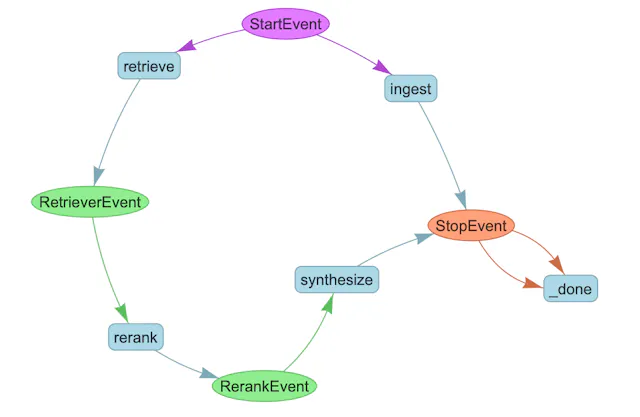

In [16]:
w = RAGWorkflow()

In [18]:
# Ingest the documents
await w.run(dirname="data")

'Indexed 77 documents.'

In [19]:
# Run a query
result = await w.run(query="How was Llama2 trained?")
async for chunk in result.async_response_gen():
    print(chunk, end="", flush=True)

Query the database with: How was Llama2 trained?
Retrieved 2 nodes.
How was Llama2 trained?
Reranked nodes to 2
Llama 2 was trained using a new mix of publicly available online data. The models were trained with a global batch size of 4 million tokens. The training hardware included Meta’s Research Super Cluster (RSC) and internal production clusters, both utilizing NVIDIA A100s. The training process involved comparing different types of interconnects, such as NVIDIA Quantum InfiniBand and RoCE (RDMA over converged Ethernet), to determine their suitability for large-scale training.